In [12]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import math
import numpy as np
import datetime
from functools import reduce
from matplotlib import pyplot as plt
from soccerlearn.features import *
    
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


SMALL_SIZE=17
MEDIUM_SIZE=SMALL_SIZE+5
BIGGER_SIZE=MEDIUM_SIZE+5

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', dpi=200)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
fixtures_and_odds = pd.read_csv('../data/fixtures_and_odds_La Liga_2014-07-01_2020-07-01.csv')
season_data = pd.read_csv('../data/seasons.csv').rename(columns={'id': 'season_id', 'name': 'season_name'})
fixtures_and_odds = pd.merge(fixtures_and_odds, season_data[['season_id', 'season_name']], on='season_id', how='left')
fixtures_and_odds['season_start_year'] = fixtures_and_odds['season_name'].apply(lambda x: x.split('/')[0])
fixtures_and_odds['date_time'] = pd.to_datetime(fixtures_and_odds['time'].apply(lambda x: eval(x)['starting_at']['date_time']))
fixtures_and_odds['year'] = fixtures_and_odds['date_time'].dt.year
fixtures_and_odds['month'] = fixtures_and_odds['date_time'].dt.month
fixtures_and_odds['date'] = fixtures_and_odds['date_time'].dt.date
fixtures_and_odds['round_id'] = fixtures_and_odds['round_id'].apply(lambda x: np.nan if math.isnan(x) else str(int(x)))
date_to_season = fixtures_and_odds.groupby('date')[['season_id']].first()
standings_data = pd.read_csv('../data/standings_La Liga.csv')
data = {'fixtures': fixtures_and_odds, 'standings': standings_data}
data['fixtures'] = unpivot_fixtures_by_odds(data)

pipeline =  Pipeline([
    ('pivot_fixtures_by_team', pivot_fixtures_by_team, {}),
    ('get_scores', get_scores, {}),
    ('get_results', get_results, {}),
    ('get_games_played', get_games_played_current_season, {}),
    ('get_cumulative_results', get_cumulative_results_current_season, {}),
    ('get_winning_odds', get_winning_odds, {}),
])
team_features = pipeline.transform(data)
teams = pd.read_csv('../data/teams_league_La Liga.csv').rename(columns={'id': 'team_id'}).groupby('team_id')[['name', 'short_code']].first()

team_features = team_features.join(teams, how='outer')
team_features = pd.merge(team_features, compute_position_end_season(data), left_on=['season_id', 'team_id'], right_index=True, how='left')
data = {'fixture_features': team_features}
team_features = pd.merge(data['fixture_features'], compute_previous_season_features(data), left_on=['season_start_year', 'team_id'], right_index=True, how='left')
print(team_features.shape)
team_features.head()

Creating feature pivot_fixtures_by_team
Creating feature get_scores
Creating feature get_results
Creating feature get_games_played
Creating feature get_cumulative_results
Creating feature get_winning_odds
(4560, 34)


round_id  \
team_id date                  
36      2014-08-24    54887   
        2014-08-30    54895   
        2014-09-13    54903   
        2014-09-20    54911   
        2014-09-23    54921   

                                                               scores  \
team_id date                                                            
36      2014-08-24  {'localteam_score': 3, 'visitorteam_score': 1,...   
        2014-08-30  {'localteam_score': 1, 'visitorteam_score': 1,...   
        2014-09-13  {'localteam_score': 2, 'visitorteam_score': 2,...   
        2014-09-20  {'localteam_score': 2, 'visitorteam_score': 2,...   
        2014-09-23  {'localteam_score': 2, 'visitorteam_score': 1,...   

                    winner_team_id  season_id season_start_year  \
team_id date                                                      
36      2014-08-24            36.0       2061              2014   
        2014-08-30             NaN       2061              2014   
        2014-09-13             NaN       2061              2014   
        2014-09-20             NaN       2061              2014   
        2014-09-23            36.0       2061              2014   

                    winning_odds_calculated  odd_value_1  odd_value_2  \
team_id date                                                            
36      2014-08-24                     True          NaN          NaN   
        2014-08-30                     True          NaN          NaN   
        2014-09-13                     True          NaN          NaN   
        2014-09-20                     True          NaN          NaN   
        2014-09-23                     True          NaN          NaN   

                    odd_value_X  odd_winning_1  ...  \
team_id date                                    ...   
36      2014-08-24          NaN            NaN  ...   
        2014-08-30          NaN            NaN  ...   
        2014-09-13          NaN            NaN  ...   
        2014-09-20          NaN            NaN  ...   
        2014-09-23          NaN            NaN  ...   

                    goals_conceded_current_season  points_current_season  \
team_id date                                                               
36      2014-08-24                              1                      3   
        2014-08-30                              2                      4   
        2014-09-13                              4                      5   
        2014-09-20                              6                      6   
        2014-09-23                              7                      9   

                    winning_odds           name  short_code  \
team_id date                                                  
36      2014-08-24           NaN  Celta de Vigo         CLV   
        2014-08-30           NaN  Celta de Vigo         CLV   
        2014-09-13           NaN  Celta de Vigo         CLV   
        2014-09-20           NaN  Celta de Vigo         CLV   
        2014-09-23           NaN  Celta de Vigo         CLV   

                   position_end_season  position_end_season_lag_1  \
team_id date                                                        
36      2014-08-24                   8                        NaN   
        2014-08-30                   8                        NaN   
        2014-09-13                   8                        NaN   
        2014-09-20                   8                        NaN   
        2014-09-23                   8                        NaN   

                    goals_scored_end_season_lag_1  points_end_season_lag_1  \
team_id date                                                                 
36      2014-08-24                            NaN                      NaN   
        2014-08-30                            NaN                      NaN   
        2014-09-13                            NaN                      NaN   
        2014-09-20                            NaN                      N

In [4]:
team_features_per_season = team_features.groupby(['short_code', 'season_id']).agg({
    **{col: 'max' for col in team_features.columns if 'current' in col or col == 'name'},
})
team_features_per_season['points_current_season'] = team_features_per_season['win_current_season'] * 3\
    + team_features_per_season['draw_current_season']
team_features_per_season.head()

games_played_current_season  win_current_season  \
short_code season_id                                                    
ALV        853                                 38                  14   
           8442                                38                  15   
           13133                               38                  13   
           16326                               38                   0   
ATH        853                                 38                  19   

                      draw_current_season  goals_scored_current_season  \
short_code season_id                                                     
ALV        853                         13                           41   
           8442                         2                           40   
           13133                       11                           39   
           16326                        0                            0   
ATH        853                          6                           53   

                      goals_conceded_current_season              name  \
short_code season_id                                                    
ALV        853                                   43  Deportivo Alavés   
           8442                                  50  Deportivo Alavés   
           13133                                 50  Deportivo Alavés   
           16326                                  0  Deportivo Alavés   
ATH        853                                   43     Athletic Club   

                      points_current_season  
short_code season_id                         
ALV        853                           55  
           8442                          47  
           13133                         50  
           16326                          0  
ATH        853                           63

Text(0, 0.5, 'Points')

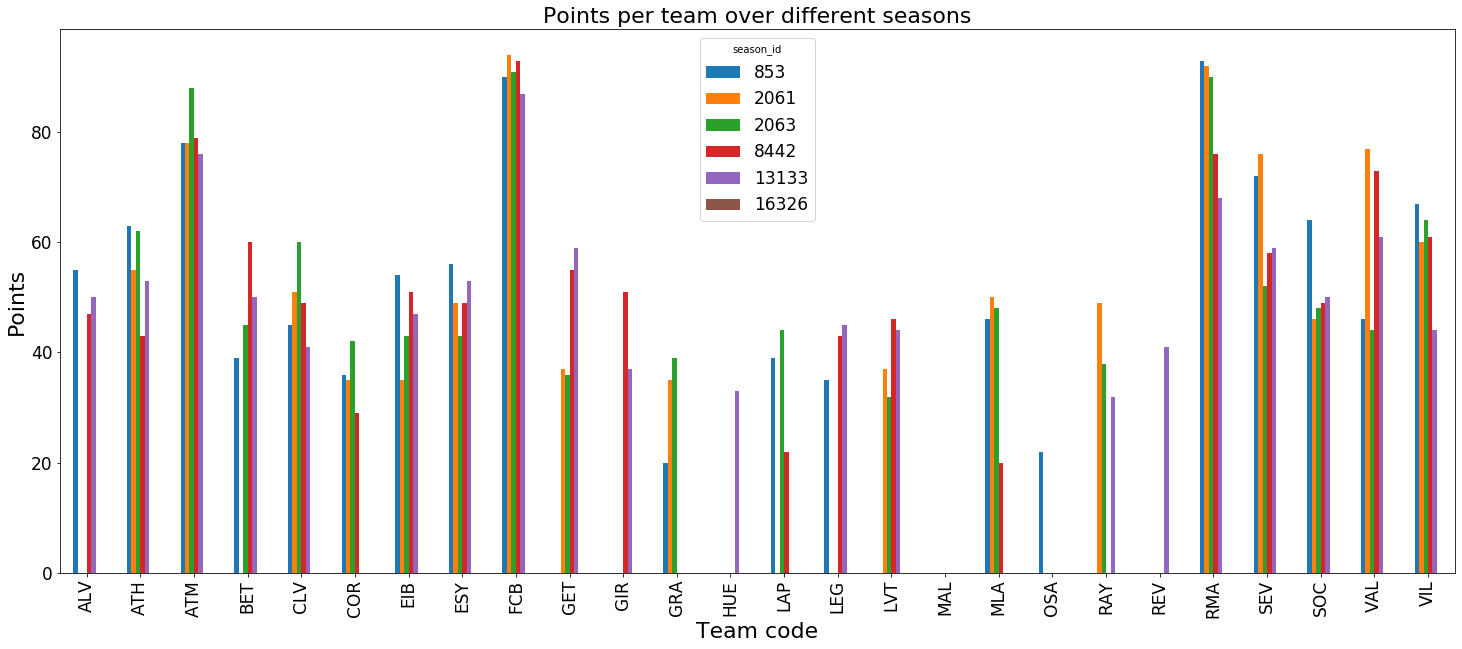

In [6]:
team_features_per_season.reset_index().pivot("short_code", "season_id", "points_current_season").plot(kind='bar', figsize=(25, 10))
plt.title('Points per team over different seasons')
plt.xlabel('Team code')
plt.ylabel('Points')

Text(0, 0.5, 'Goals scored')

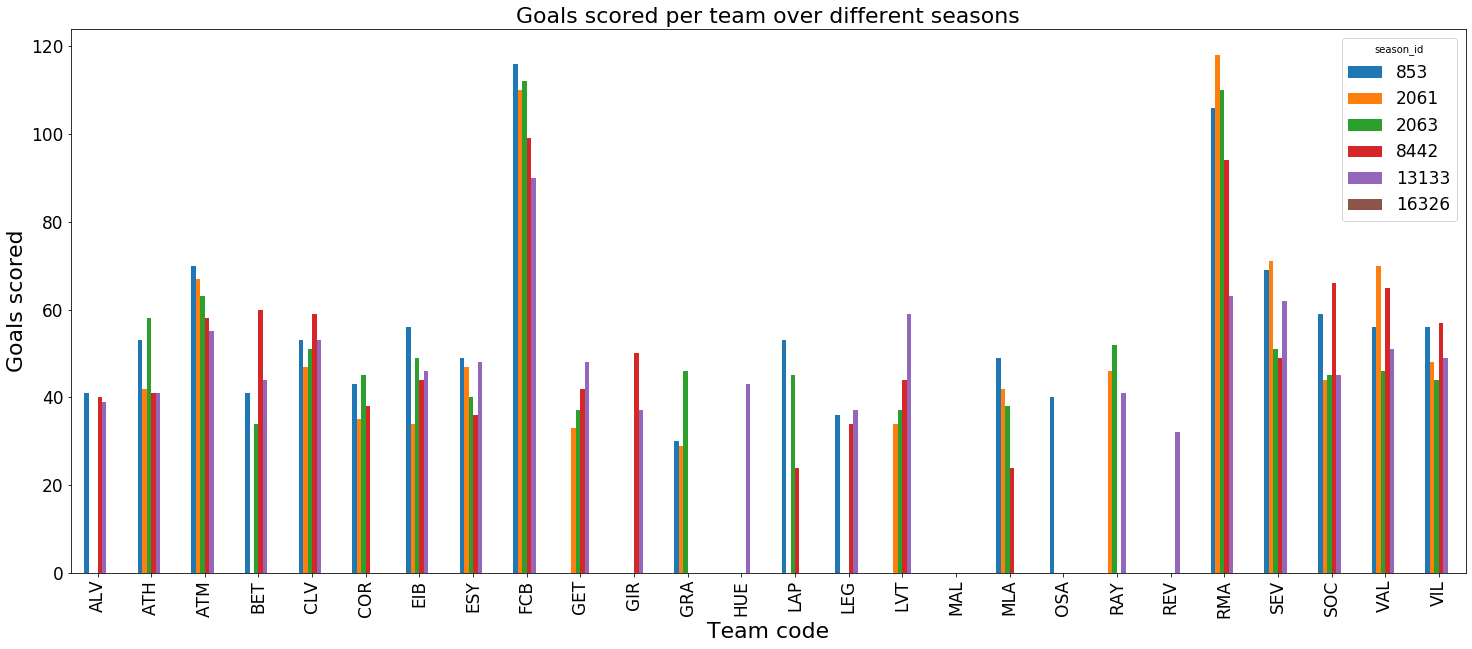

In [11]:
team_features_per_season.reset_index().pivot("short_code", "season_id", "goals_scored_current_season").plot(kind='bar', figsize=(25, 10))
plt.title('Goals scored per team over different seasons')
plt.xlabel('Team code')
plt.ylabel('Goals scored')

Text(0, 0.5, 'Goals conceded')

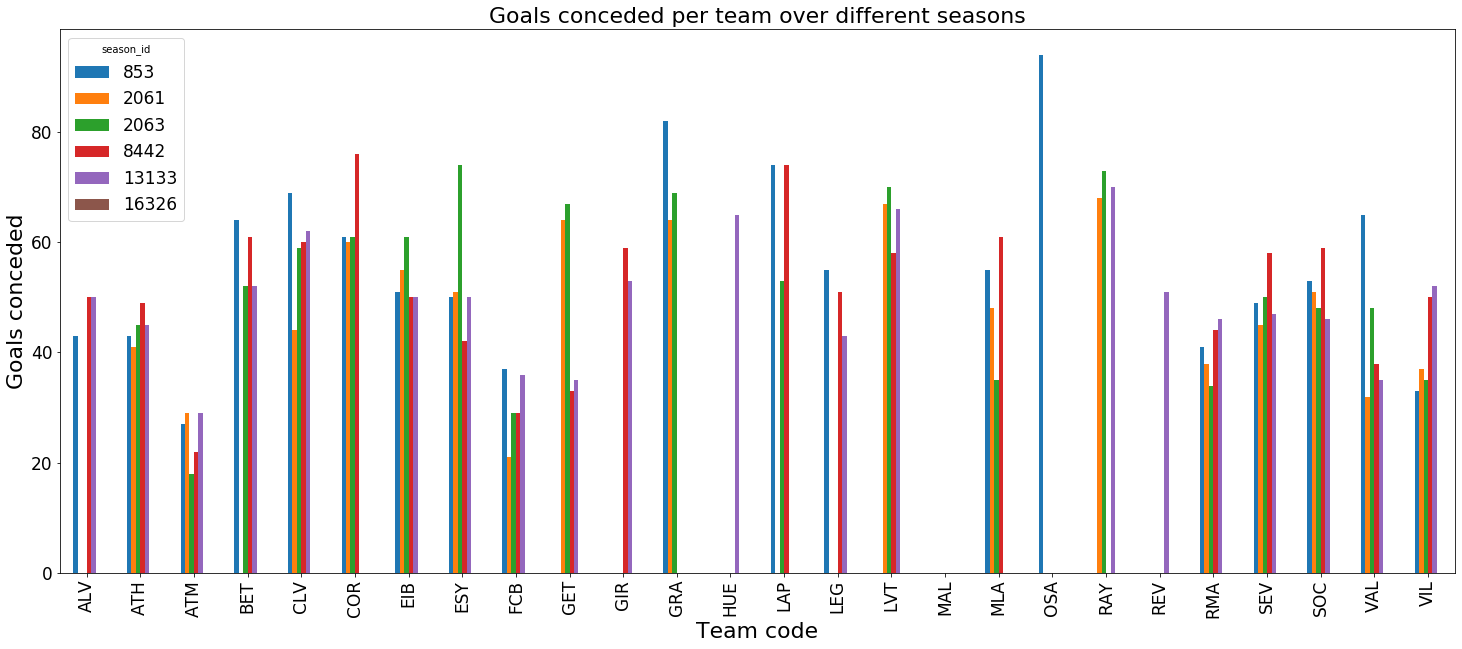

In [13]:
team_features_per_season.reset_index().pivot("short_code", "season_id", "goals_conceded_current_season").plot(kind='bar', figsize=(25, 10))
plt.title('Goals conceded per team over different seasons')
plt.xlabel('Team code')
plt.ylabel('Goals conceded')

In [5]:
team_features['winning_odds']

count    760.000000
mean       3.422947
std        2.021485
min        1.140000
25%        2.200000
50%        2.870000
75%        4.000000
max       17.000000
Name: winning_odds, dtype: float64

team_id  date      
13258    2020-05-03   NaN
         2020-05-10   NaN
         2020-05-13   NaN
         2020-05-17   NaN
         2020-05-24   NaN
Name: current_position, dtype: float64

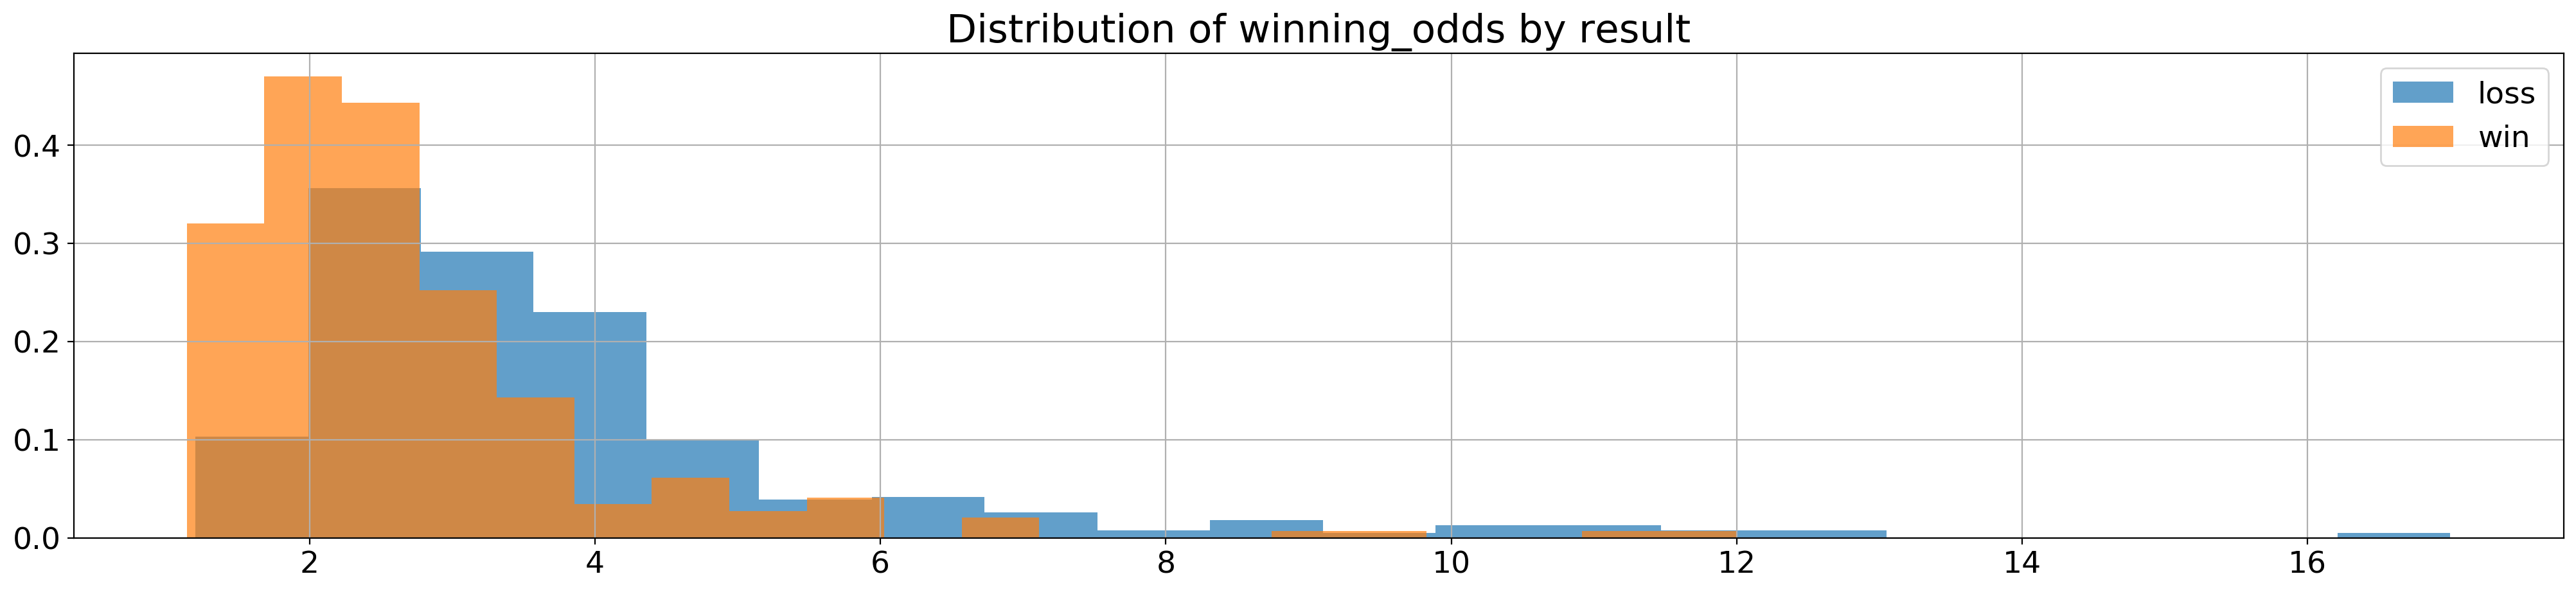

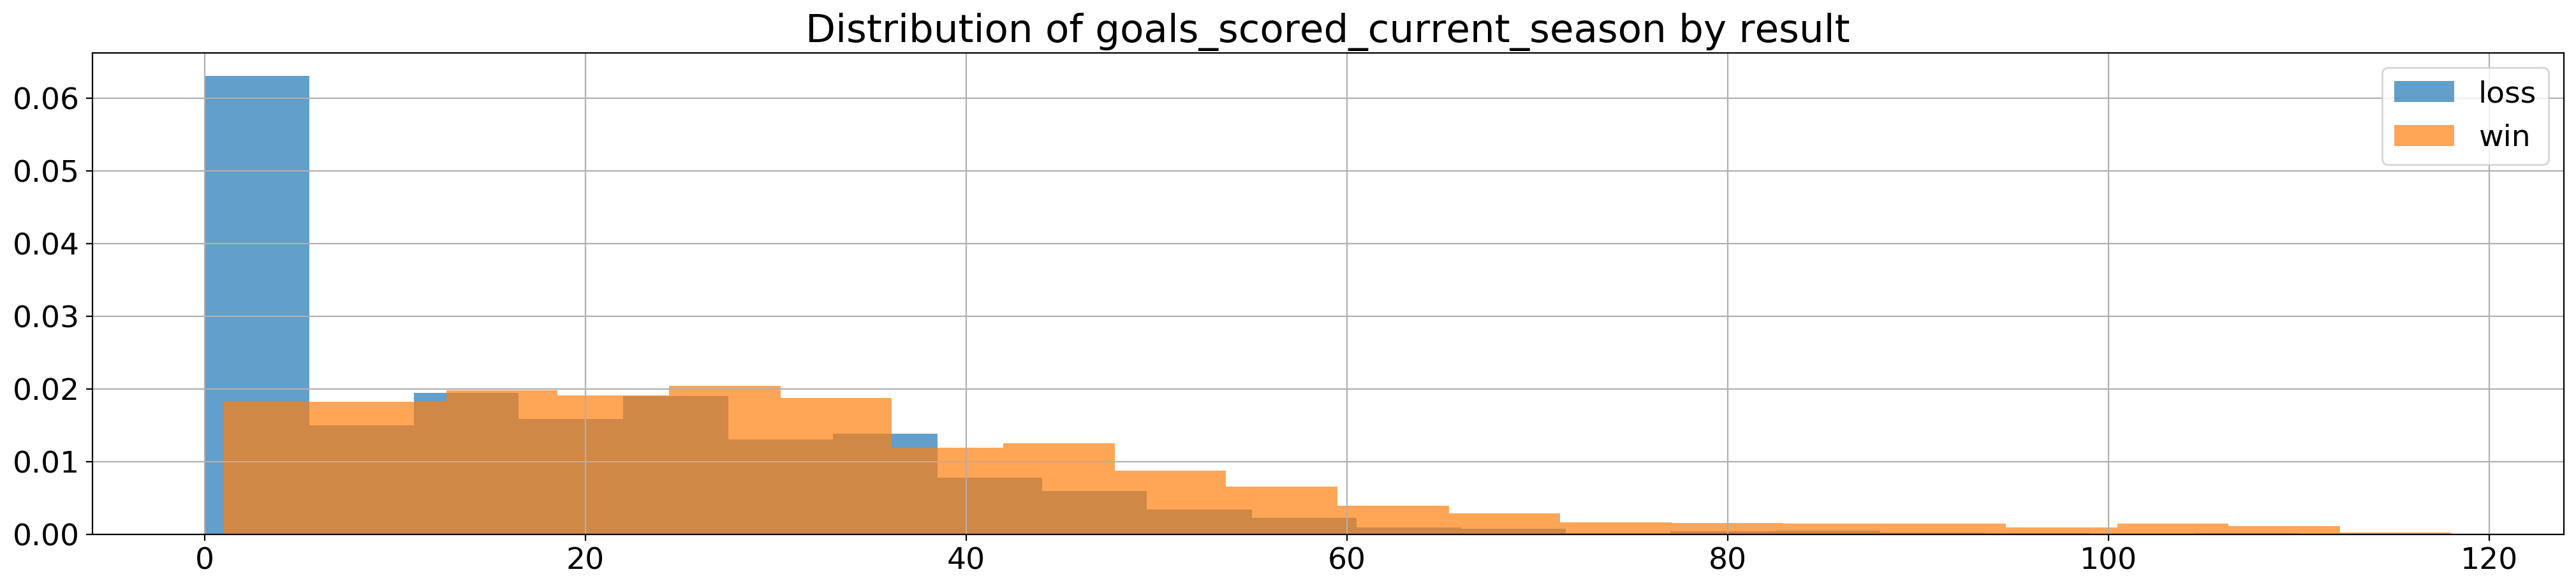

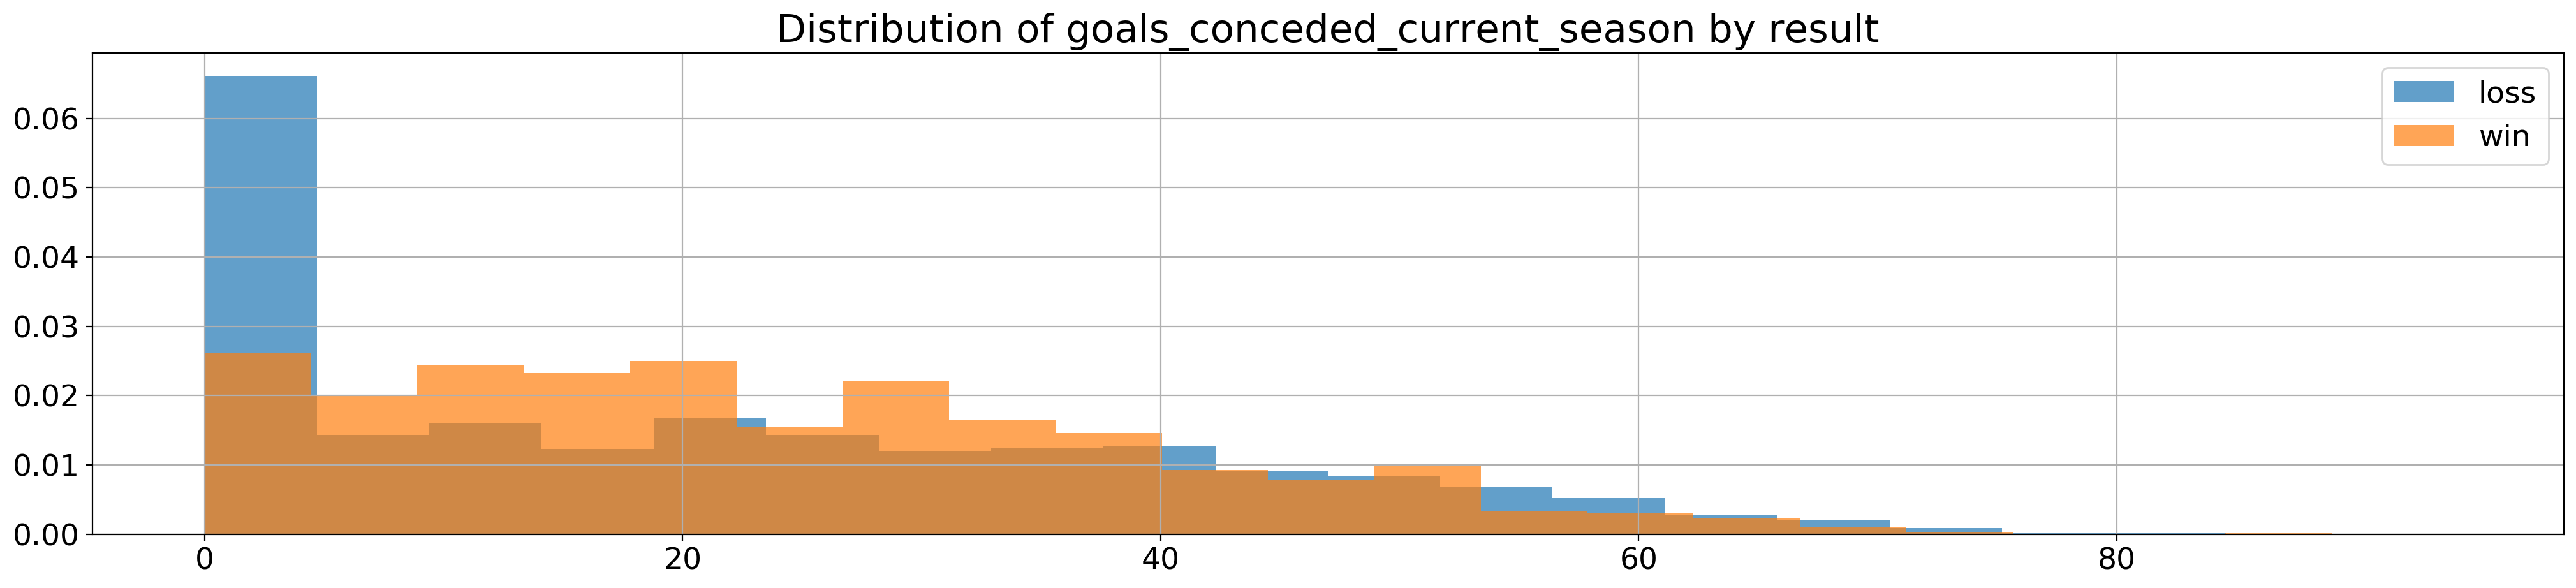

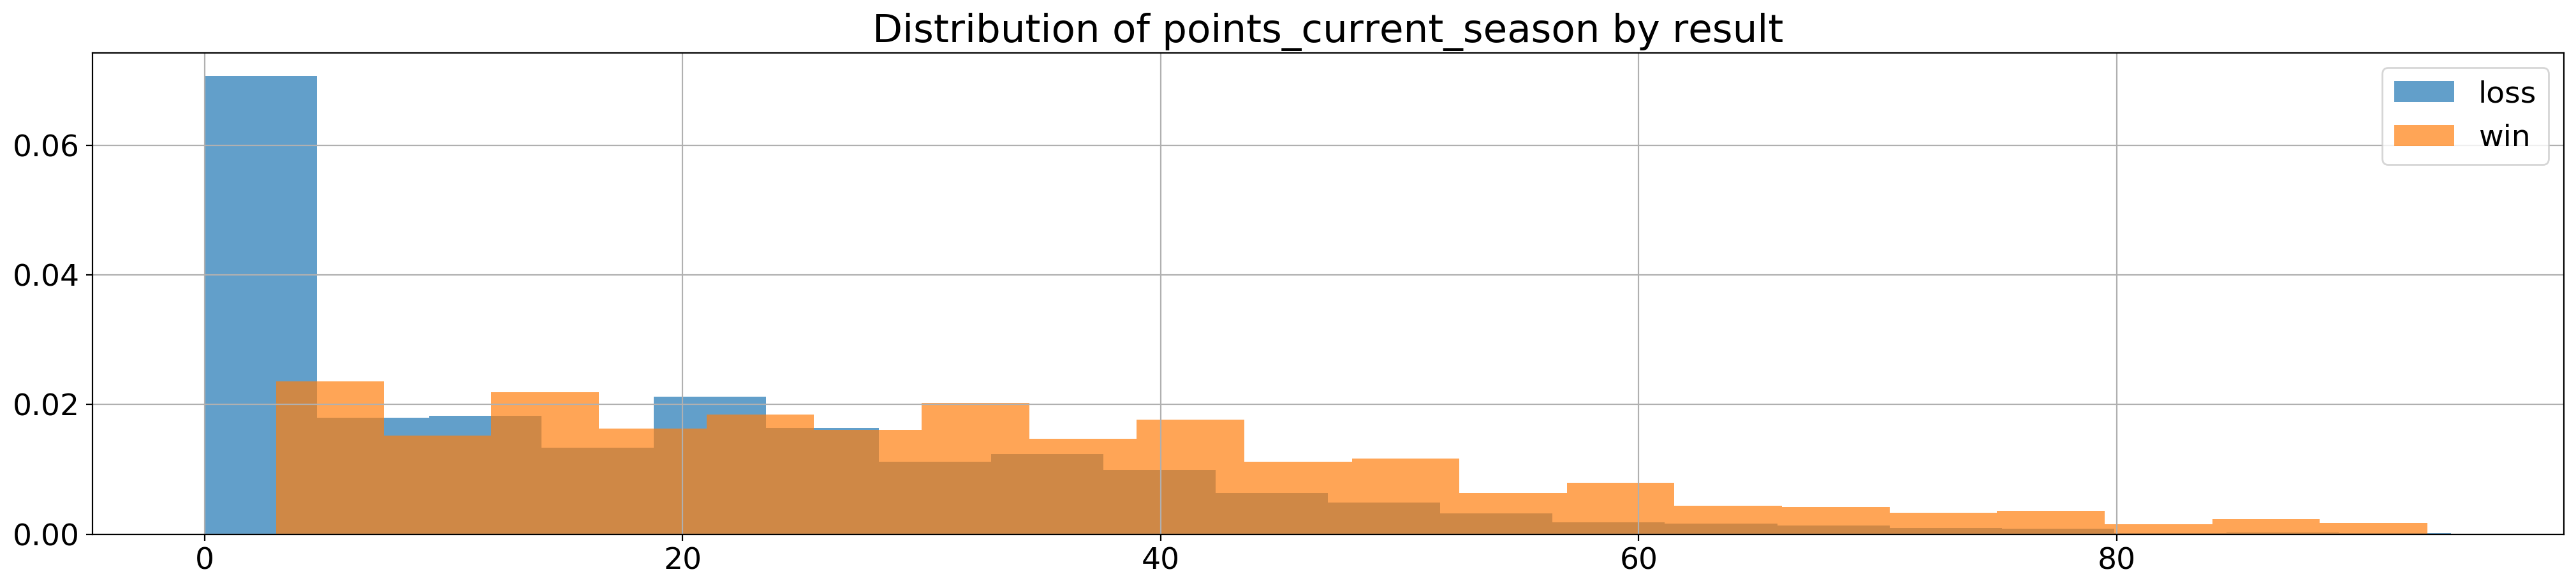

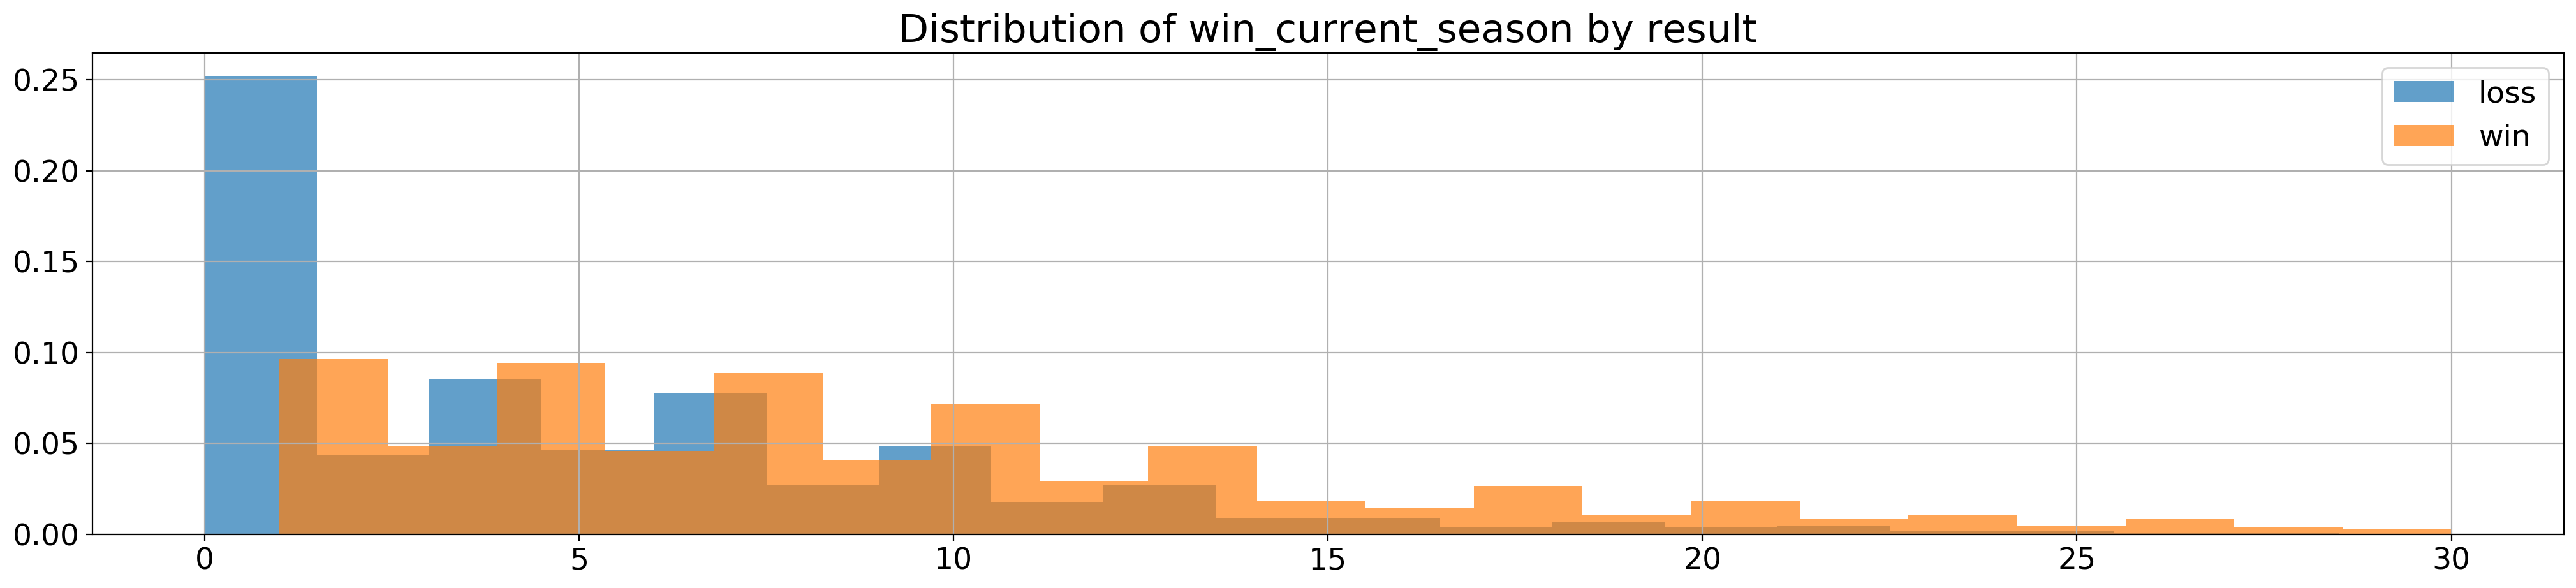

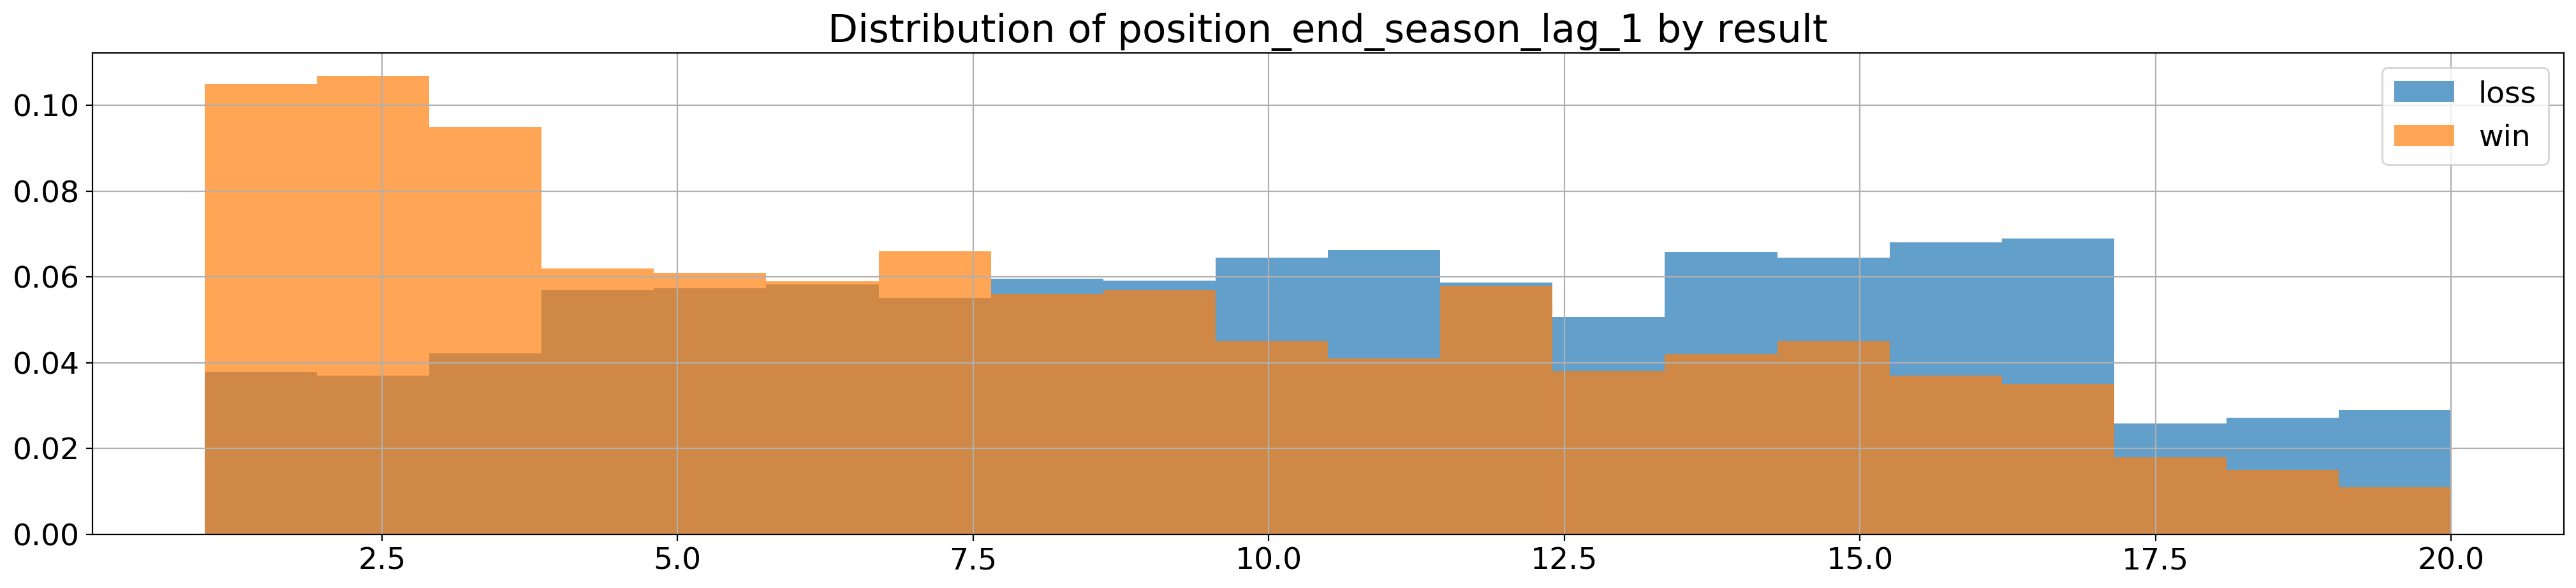

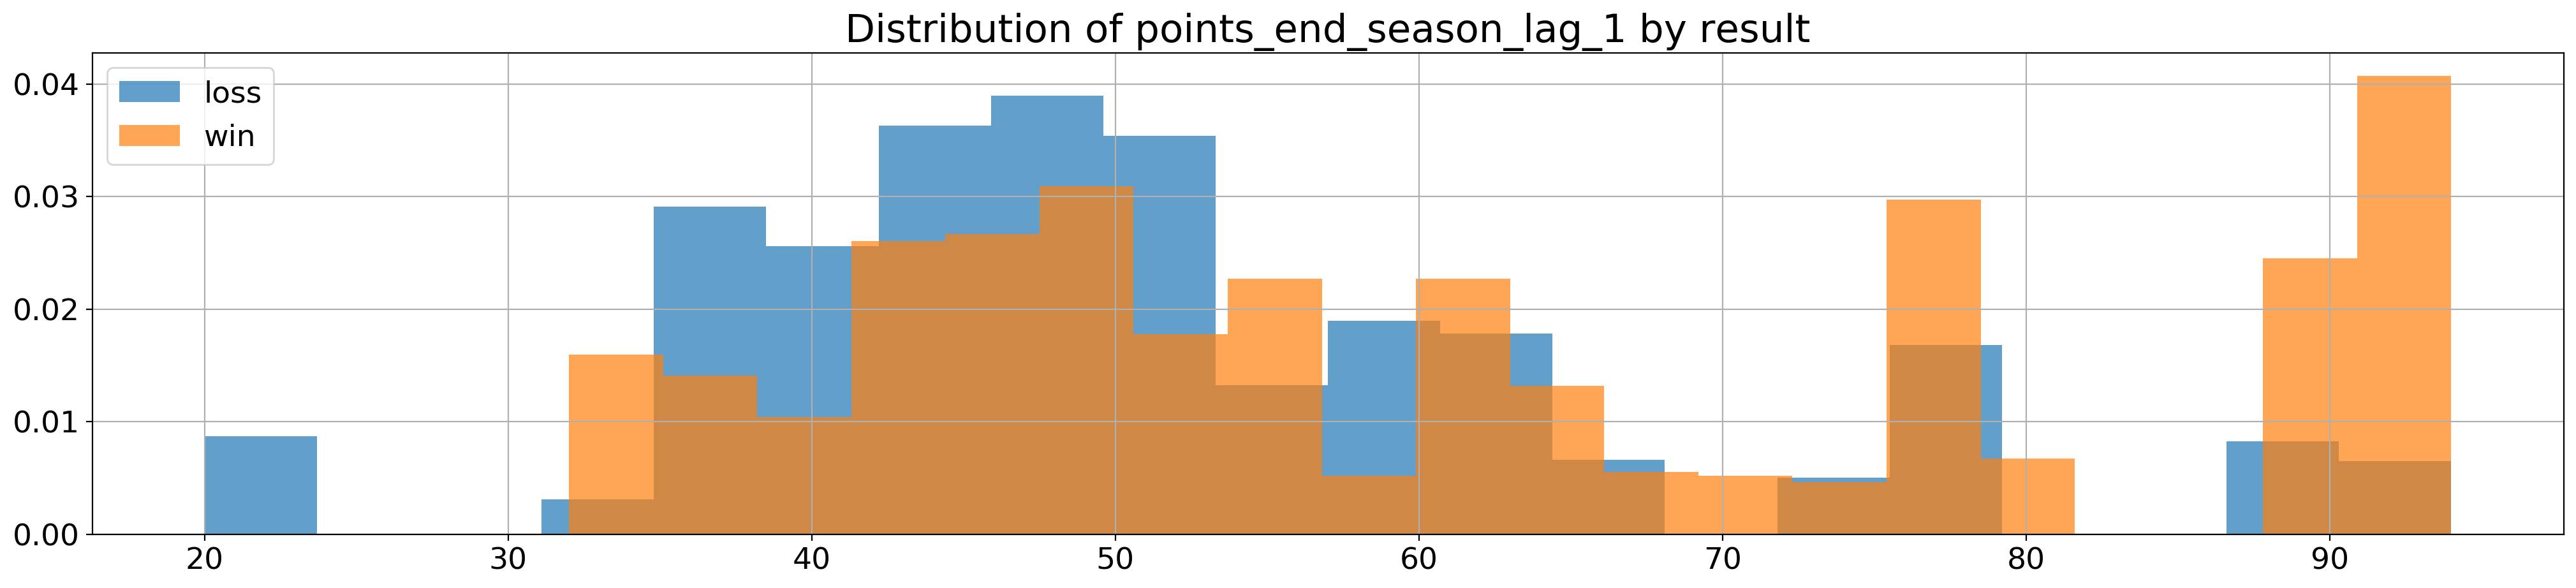

In [16]:
name_dict = {0: 'loss', 1: 'win'}
vars_ = ['winning_odds', 'goals_scored_current_season', 'goals_conceded_current_season',
         'points_current_season', 'win_current_season', 'position_end_season_lag_1', 'points_end_season_lag_1']
for var in vars_:
    fig, ax = plt.subplots(figsize=(25, 5))
    for i in [0, 1]:
        team_features.loc[team_features['win'] == i, var].hist(ax=ax, bins=20, label=name_dict[i], alpha=0.7, density=True)
    
    ax.set_title(f'Distribution of {var} by result')
    plt.legend()

In [28]:
data['pivot_fixtures_by_team'].head()

,,round_id,scores,winner_team_id,season_id,winning_odds_calculated,odd_value_1,odd_value_2,odd_value_X,odd_winning_1,odd_winning_2,odd_winning_X,local
team_id,date,,,,,,,,,,,,
126,2014-08-23,54887.0,"{'localteam_score': 1, 'visitorteam_score': 0,...",126.0,2061,True,NaN,NaN,NaN,NaN,NaN,NaN,True
676,2014-08-23,54887.0,"{'localteam_score': 1, 'visitorteam_score': 1,...",NaN,2061,True,NaN,NaN,NaN,NaN,NaN,NaN,True
103,2014-08-23,54887.0,"{'localteam_score': 2, 'visitorteam_score': 1,...",103.0,2061,True,NaN,NaN,NaN,NaN,NaN,NaN,True
618,2014-08-23,54887.0,"{'localteam_score': 1, 'visitorteam_score': 1,...",NaN,2061,True,NaN,NaN,NaN,NaN,NaN,NaN,True
60,2014-08-24,54887.0,"{'localteam_score': 1, 'visitorteam_score': 0,...",60.0,2061,True,NaN,NaN,NaN,NaN,NaN,NaN,True


In [37]:
team_features.shape

(4560, 29)

In [63]:
compute_current_positions(data).groupby('season_id').size()

season_id
853      20
2052     20
2053     20
2054     20
2055     20
2056     20
2057     20
2058     20
2059     20
2060     20
2061     20
2063     20
8442     20
13133    20
16326    20
dtype: int64

In [ ]:
compute_current_positions(data).head()

In [18]:
standings_data['season_id'].unique()

array([ 2052,  2053,  2054,  2055,  2058,  2056,  2057,  2059,  2060,
        2061,  2063,   853,  8442, 13133, 16326])

In [72]:
season_data = pd.read_csv('../data/seasons.csv')

In [82]:
season_data['year'] = season_data['name'].apply(lambda x: x.split('/')[0])
season_data.loc[season_data['league_id'] == 564]

,Unnamed: 0,current_round_id,current_stage_id,id,is_current_season,league_id,name,year
333,333,NaN,NaN,2052,False,564,2005/2006,2005
334,334,NaN,NaN,2053,False,564,2006/2007,2006
335,335,NaN,NaN,2054,False,564,2007/2008,2007
336,336,NaN,NaN,2055,False,564,2008/2009,2008
337,337,NaN,NaN,2058,False,564,2009/2010,2009
338,338,NaN,NaN,2056,False,564,2010/2011,2010
339,339,NaN,NaN,2057,False,564,2011/2012,2011
340,340,NaN,NaN,2059,False,564,2012/2013,2012
341,341,NaN,NaN,2060,False,564,2013/2014,2013
342,342,NaN,NaN,2061,False,564,2014/2015,2014


In [76]:
season_data['league_id'].unique()

array([   2,    5,    8,    9,   12,   24,   72,   82,  163,  166,  181,
        208,  211,  217,  271,  274,  301,  384,  390,  444,  462,  486,
        495,  501,  525,  528,  564,  570,  573,  600,  609, 1128, 1353,
       1371])

In [80]:
fixtures_and_odds['league_id'].iloc[0]

564